In [2]:
import os
import glob
import random
import numpy as np  
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [3]:
# USER CONFIG - change paths
IMAGE_DIR = r"D:\Mini Project\dataset\Brain Tumor Segmentation\images"
MASK_DIR  = r"D:\Mini Project\dataset\Brain Tumor Segmentation\masks"
SAVE_MODEL_PATH_H5    = r"./segmentation_unet.h5"
SAVE_MODEL_PATH_KERAS = r"./segmentation_unet.keras"
IMG_SIZE = (128, 128)   # network input size (H, W)
BATCH_SIZE = 8
EPOCHS = 10
SEED = 42

In [4]:
# Fix random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# Utility: find image-mask pairs
def get_image_mask_pairs(image_dir, mask_dir, image_exts=('png','jpg','jpeg','tif')):
    images = []
    for ext in image_exts:
        images += glob.glob(os.path.join(image_dir, f"*.{ext}"))
    images = sorted(images)
    pairs = []
    for img_path in images:
        fname = os.path.basename(img_path)
        # expect same file name in masks (or modify mapping logic here)
        mask_path = os.path.join(mask_dir, fname)
        if os.path.exists(mask_path):
            pairs.append((img_path, mask_path))
        else:
            # try small variations (e.g. suffix _mask)
            alt = os.path.splitext(fname)[0] + "_mask" + os.path.splitext(fname)[1]
            alt_path = os.path.join(mask_dir, alt)
            if os.path.exists(alt_path):
                pairs.append((img_path, alt_path))
    return pairs

pairs = get_image_mask_pairs(IMAGE_DIR, MASK_DIR)
if len(pairs) == 0:
    raise SystemExit("No image-mask pairs found. Check IMAGE_DIR and MASK_DIR paths and filenames.")

print(f"Found {len(pairs)} image-mask pairs.")

Found 3064 image-mask pairs.


In [5]:
# TF Data pipeline
AUTOTUNE = tf.data.AUTOTUNE
IMG_H, IMG_W = IMG_SIZE

def load_image_mask(img_path, mask_path):
    # read image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, [IMG_H, IMG_W])
    img = tf.cast(img, tf.float32) / 255.0

    # read mask (grayscale / binary)
    m = tf.io.read_file(mask_path)
    m = tf.image.decode_image(m, channels=1)
    m.set_shape([None, None, 1])
    m = tf.image.resize(m, [IMG_H, IMG_W], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    m = tf.cast(m, tf.float32) / 255.0
    # ensure mask is binary (0 or 1)
    m = tf.where(m >= 0.5, 1.0, 0.0)
    return img, m

In [6]:
# Simple augmentations
def augment(img, mask):
    # random flip
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    # random rotation by multiples of 90
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)

    # random brightness / contrast (image only)
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, mask

def make_dataset(pairs, batch_size=BATCH_SIZE, training=True):
    img_paths = [p for p, _ in pairs]
    mask_paths = [m for _, m in pairs]
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.shuffle(len(pairs), seed=SEED) if training else ds
    ds = ds.map(lambda x, y: tf.py_function(func=lambda a,b: load_image_mask(a.numpy().decode('utf-8'), b.numpy().decode('utf-8')),
                                           inp=[x,y],
                                           Tout=(tf.float32, tf.float32)),
                num_parallel_calls=AUTOTUNE)
    # set shapes (py_function loses static shapes)
    ds = ds.map(lambda img, mask: (tf.reshape(img, [IMG_H, IMG_W, 3]), tf.reshape(mask, [IMG_H, IMG_W, 1])),
                num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: augment(x,y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

In [7]:
# Build U-Net
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    return x

def build_unet(input_shape=(IMG_H, IMG_W, 3), base_filters=32):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, base_filters)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = conv_block(p1, base_filters*2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = conv_block(p2, base_filters*4)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    b = conv_block(p3, base_filters*8)

    # Decoder
    u1 = layers.Conv2DTranspose(base_filters*4, 2, strides=2, padding='same')(b)
    u1 = layers.concatenate([u1, c3])
    c4 = conv_block(u1, base_filters*4)

    u2 = layers.Conv2DTranspose(base_filters*2, 2, strides=2, padding='same')(c4)
    u2 = layers.concatenate([u2, c2])
    c5 = conv_block(u2, base_filters*2)

    u3 = layers.Conv2DTranspose(base_filters, 2, strides=2, padding='same')(c5)
    u3 = layers.concatenate([u3, c1])
    c6 = conv_block(u3, base_filters)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c6)
    model = Model(inputs, outputs, name='UNet')
    return model

In [8]:
# Dice coefficient and combined loss
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = BinaryCrossentropy()(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

In [9]:
# Prepare train/val split
random.shuffle(pairs)
split_idx = int(0.85 * len(pairs))
train_pairs = pairs[:split_idx]
val_pairs = pairs[split_idx:]
print(f"Train pairs: {len(train_pairs)}, Val pairs: {len(val_pairs)}")

train_ds = make_dataset(train_pairs, batch_size=BATCH_SIZE, training=True)
val_ds   = make_dataset(val_pairs, batch_size=BATCH_SIZE, training=False)

Train pairs: 2604, Val pairs: 460


Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.9824 - dice_coef: 0.0361 - loss: 1.2287
Epoch 1: val_dice_coef improved from -inf to 0.08449, saving model to ./segmentation_unet.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 304s 900ms/step - accuracy: 0.9824 - dice_coef: 0.0362 - loss: 1.2283 - val_accuracy: 0.9844 - val_dice_coef: 0.0845 - val_loss: 0.9862 - learning_rate: 1.0000e-04
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9824 - dice_coef: 0.1081 - loss: 0.9708
Epoch 2: val_dice_coef improved from 0.08449 to 0.22317, saving model to ./segmentation_unet.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.9824 - dice_coef: 0.1082 - loss: 0.9707 - val_accuracy: 0.9597 - val_dice_coef: 0.2232 - val_loss: 0.8761 - learning_rate: 1.0000e-04
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9776 - dice_coef: 0.2855 - loss: 0.8000
Epoch 3: val_dice_coef improved from 0.22317 to 0.31179, saving model to ./segmentation_unet.keras
326/3

Saved final model.


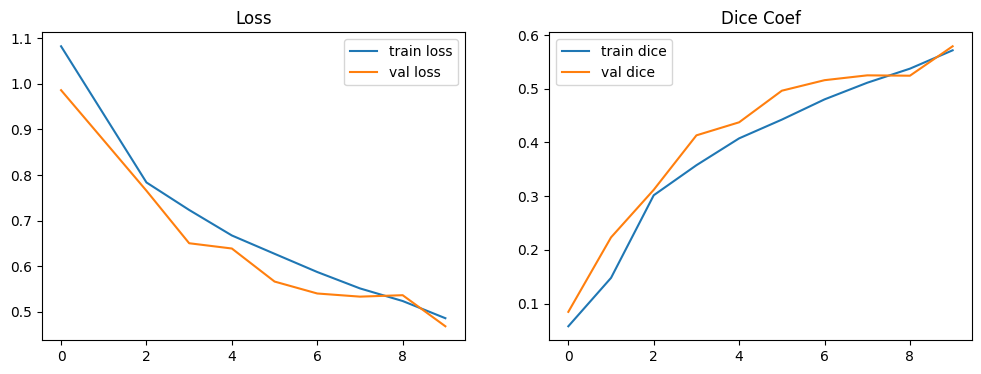

In [10]:
# Create, compile model
model = build_unet()
model.compile(optimizer=Adam(1e-4), loss=bce_dice_loss, metrics=[dice_coef, 'accuracy'])
# model.summary()


# Callbacks
callbacks = [
    ModelCheckpoint(SAVE_MODEL_PATH_KERAS, 
                    monitor='val_dice_coef', 
                    mode='max', 
                    save_best_only=True, 
                    verbose=1),
    ReduceLROnPlateau(monitor='val_loss', 
                      factor=0.5, 
                      patience=3, 
                      verbose=1, 
                      min_lr=1e-7),
    EarlyStopping(monitor='val_dice_coef', 
                  mode='max', 
                  patience=8, 
                  restore_best_weights=True, 
                  verbose=1)
]



# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

model.save(SAVE_MODEL_PATH_H5)

# Save in native Keras format (.keras)
model.save(SAVE_MODEL_PATH_KERAS)
print("Saved final model.")


# ---------------------------
# Plot training curves
# ---------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'], label='train dice')
plt.plot(history.history['val_dice_coef'], label='val dice')
plt.legend(); plt.title('Dice Coef')
plt.show()

In [18]:
model.save("segmentation_model.keras")

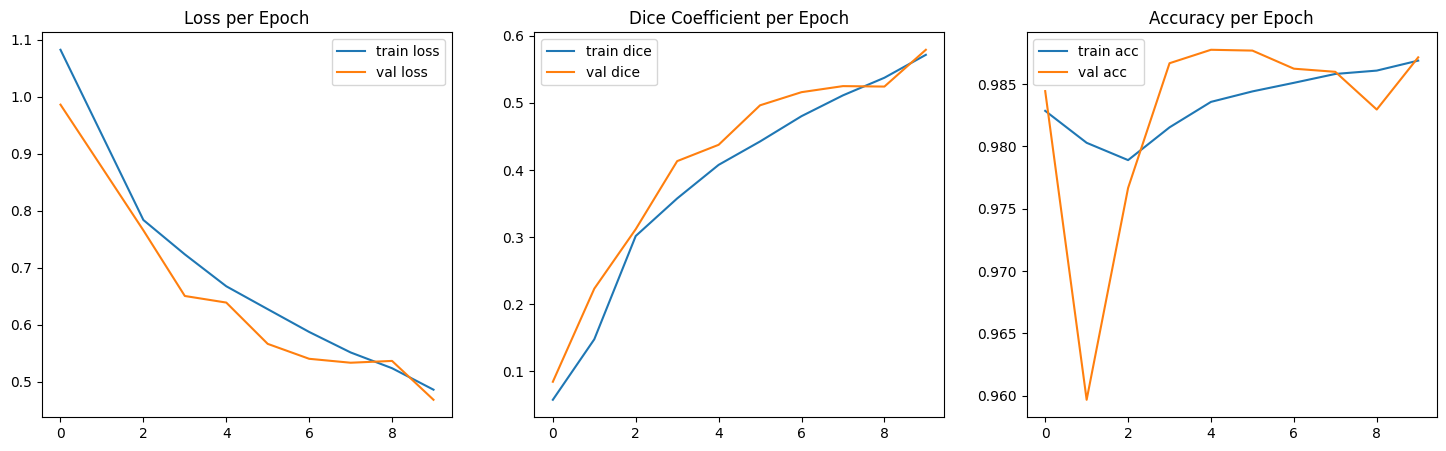

In [12]:
# ---------------------------
# Plot training curves (Loss, Dice, Accuracy)
# ---------------------------
plt.figure(figsize=(18,5))

# Loss
plt.subplot(1,3,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(); plt.title('Loss per Epoch')

# Dice Coefficient
plt.subplot(1,3,2)
plt.plot(history.history['dice_coef'], label='train dice')



plt.plot(history.history['val_dice_coef'], label='val dice')
plt.legend(); plt.title('Dice Coefficient per Epoch')

# Accuracy
plt.subplot(1,3,3)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend(); plt.title('Accuracy per Epoch')

plt.show()


Demo predictions on a few validation images:


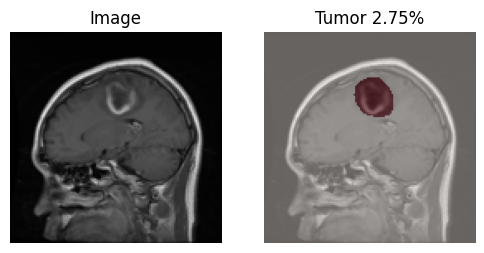

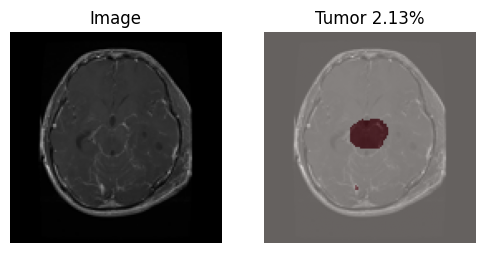

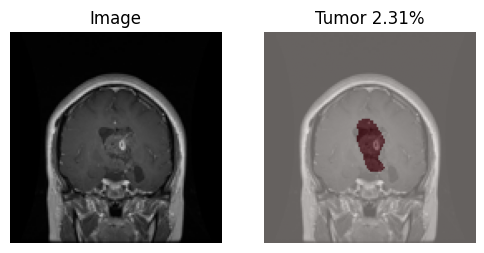

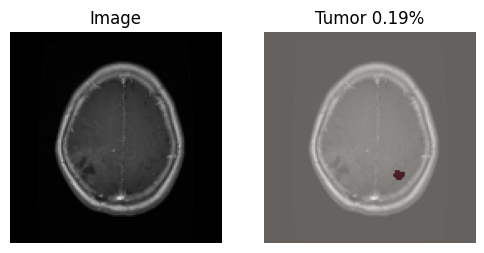

In [13]:
# ---------------------------
# Inference utilities
# ---------------------------
def predict_mask_and_percentage(image_path, model, threshold=0.5, return_resized=True):
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    img_resized = img.resize((IMG_W, IMG_H))
    img_arr = np.asarray(img_resized, dtype=np.float32) / 255.0
    input_tensor = np.expand_dims(img_arr, axis=0)  # (1,H,W,3)

    pred = model.predict(input_tensor, verbose=0)[0,:,:,0]  # (H,W)
    mask = (pred >= threshold).astype(np.uint8)

    tumor_pct = mask.sum() / mask.size * 100.0

    if return_resized:
        return mask, tumor_pct, img_resized
    else:
        return mask, tumor_pct

# Quick demo on few validation images
print("\nDemo predictions on a few validation images:")
n_demo = min(4, len(val_pairs))
for i in range(n_demo):
    img_path, _ = val_pairs[i]
    mask, pct, img_resized = predict_mask_and_percentage(img_path, model)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(img_resized); plt.title("Image"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(img_resized); plt.imshow(mask, cmap='Reds', alpha=0.4); plt.title(f"Tumor {pct:.2f}%"); plt.axis('off')
    plt.show()

In [14]:

# ---------------------------
# Helper to integrate with your classifier
# ---------------------------
def detect_with_segmentation(image_path, classifier_model=None, seg_model=None, class_labels=None):
    """
    If classifier_model is provided, it will also compute the predicted class and confidence.
    seg_model must be a trained segmentation model (or the model returned above).
    """
    if seg_model is None:
        raise ValueError("Provide seg_model (trained segmentation model).")

    mask, pct, img_resized = predict_mask_and_percentage(image_path, seg_model)
    result = {
        'tumor_percentage': pct,
        'mask': mask,
    }

    if classifier_model is not None and class_labels is not None:
        x = np.expand_dims(np.asarray(img_resized, dtype=np.float32)/255.0, axis=0)
        preds = classifier_model.predict(x, verbose=0)
        cls_idx = int(np.argmax(preds))
        result.update({
            'predicted_class': class_labels[cls_idx],
            'confidence': float(np.max(preds)) * 100.0
        })
    return result

print("\nScript finished. Use detect_with_segmentation(...) to run combined inference.")



Script finished. Use detect_with_segmentation(...) to run combined inference.


In [16]:
model.save("segmentation_model.h5")